# Hierarchical clustering (best model)

https://scikit-learn.org/stable/modules/clustering.html

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 50) 
pd.set_option('display.max_columns', None)

In [56]:
df = pd.read_csv('df_tight.csv')

In [57]:
df.columns

Index(['Strain', 'Lean', 'Sweet', 'Earthy', 'Spicy/Herbal', 'Tropical',
       'Pungent', 'Flowery', 'Blueberry', 'Berry', 'Pine', 'Woody', 'Citrus',
       'Diesel', 'Lemon_Lime', 'Appearment', 'Grape', 'Skunk', 'Eff_Focused',
       'Med_Inflammation', 'Eff_Dizzy', 'Eff_Energetic', 'Eff_Dry_eyes',
       'Med_Lack_of_appetite', 'Eff_Happy', 'Eff_Creative',
       'Med_Muscle_spasms', 'Eff_Sleepy', 'Med_Stress', 'Eff_Tingly',
       'Eff_Aroused', 'Eff_Anxious', 'Med_Nausea', 'Med_Fatigue', 'Med_Cramps',
       'Eff_Uplifted', 'Eff_Headache', 'Eff_Talkative', 'Eff_Paranoid',
       'Eff_Hungry', 'Eff_Giggly', 'Med_Depression', 'Eff_Relaxed', 'Med_Pain',
       'Eff_Euphoric', 'Med_Eye_pressure', 'Eff_Dry_mouth', 'Med_Headaches',
       'Med_Insomnia', 'Rating_scaled', 'Num_reviews_scaled', 'THC_scaled',
       'Strain_type', 'Apricot_Grapefruit'],
      dtype='object')

In [58]:
useful_features_15 = ['Citrus', 'Eff_Energetic', 'Eff_Relaxed', 'Earthy', 'Med_Insomnia',\
                      'Eff_Uplifted', 'Med_Fatigue', 'Eff_Sleepy', 'Berry', 'Eff_Creative',\
                      'Tropical', 'Med_Pain', 'Eff_Focused', 'Lemon_Lime', 'Med_Depression']

general_features = ['Sweet', 'Earthy', 'Spicy/Herbal', 'Tropical',
       'Pungent', 'Flowery', 'Blueberry', 'Berry', 'Pine', 'Woody', 'Citrus',
       'Diesel', 'Lemon_Lime', 'Appearment', 'Grape', 'Skunk', 'Eff_Focused',
       'Med_Inflammation', 'Eff_Dizzy', 'Eff_Energetic', 'Eff_Dry_eyes',
       'Med_Lack_of_appetite', 'Eff_Happy', 'Eff_Creative',
       'Med_Muscle_spasms', 'Eff_Sleepy', 'Med_Stress', 'Eff_Tingly',
       'Eff_Aroused', 'Eff_Anxious', 'Med_Nausea', 'Med_Fatigue', 'Med_Cramps',
       'Eff_Uplifted', 'Eff_Headache', 'Eff_Talkative', 'Eff_Paranoid',
       'Eff_Hungry', 'Eff_Giggly', 'Med_Depression', 'Eff_Relaxed', 'Med_Pain',
       'Eff_Euphoric', 'Med_Eye_pressure', 'Eff_Dry_mouth', 'Med_Headaches',
       'Med_Insomnia', 'Apricot_Grapefruit']

X = df[useful_features_15]
Y = df[general_features]

In [59]:
X.columns

Index(['Citrus', 'Eff_Energetic', 'Eff_Relaxed', 'Earthy', 'Med_Insomnia',
       'Eff_Uplifted', 'Med_Fatigue', 'Eff_Sleepy', 'Berry', 'Eff_Creative',
       'Tropical', 'Med_Pain', 'Eff_Focused', 'Lemon_Lime', 'Med_Depression'],
      dtype='object')

### Graph: Scipy: dendrogram

As usual, let's use scipy to produce a dendrogram.

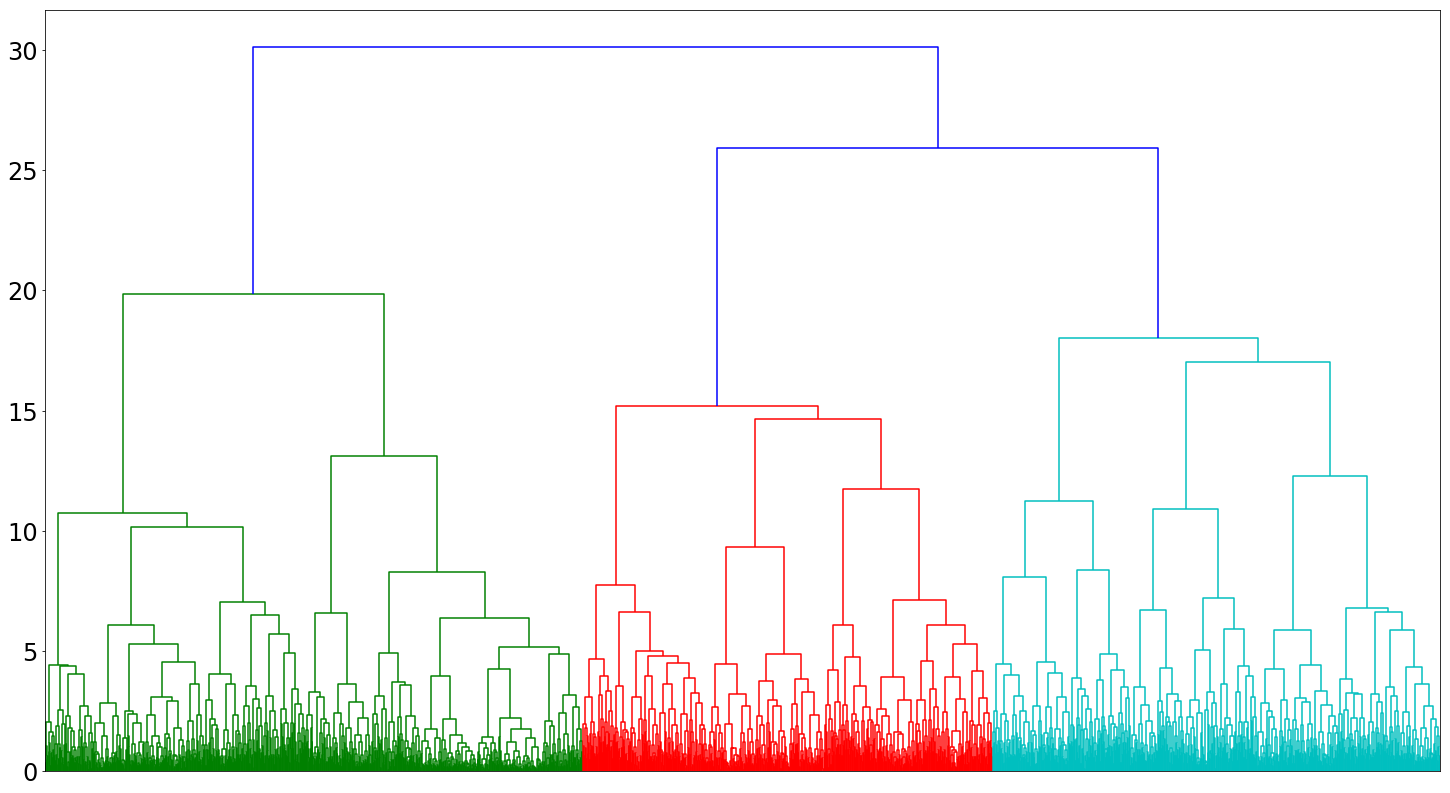

In [80]:
# Dendrogram clustering for 15 features
linky = linkage(X, method='ward')

plt.figure(figsize=(25, 14))
dendrogram(linky, no_labels=True, ) # full dendrogram
# dendrogram(linky, truncate_mode='lastp', leaf_rotation=45, leaf_font_size=20)
# plt.title('Dendrogram (tree diagram) for strain clustering (15 features)', fontsize=24)
# plt.xlabel('Strains', fontsize=24)
# plt.ylabel('Dissimilarity', fontsize=24)
plt.xticks(fontsize=0)
plt.yticks(fontsize=24)
plt.show();

These 15 features give us three clear groups, with a potential four groups if we look at the split of the green group on the left. Let's analyse our groups.

### Explore effect, medical, and flavours for k=3, 4

Let's get a column for each of our desired clusterings and append the clustering values to X. We can explore clusterings for each value of k in turn.

In [7]:
# Cluster and add columns for k = 3, 4
k_list = [3,4]
for k in k_list:
    clusters = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    clusters.fit(X)
    X[f'cluster_{k}']=clusters.labels_ # assign the cluster labels to our dataframe
    
X.columns

Index(['Citrus', 'Eff_Energetic', 'Eff_Relaxed', 'Earthy', 'Med_Insomnia',
       'Eff_Uplifted', 'Med_Fatigue', 'Eff_Sleepy', 'Berry', 'Eff_Creative',
       'Tropical', 'Med_Pain', 'Eff_Focused', 'Lemon_Lime', 'Med_Depression',
       'cluster_3', 'cluster_4'],
      dtype='object')

### Define functions

In [8]:
def make_df_c_stds(k):
    # DROP IRRELEVANT K-COLUMNS
    df_c = X.copy()
    k_list = [3,4]
    for i in k_list:
        if k != i:
            df_c.drop(f'cluster_{i}', axis=1, inplace=True)
        
    # CREATE df_stds, AN INTRA-CLUSTER STD DATAFRAME FOR EACH CLUSTER SIZE
    df_stds = pd.DataFrame()
    for i in range(0,k):
        df_cut = df_c[df_c[f'cluster_{k}'] == i]
        std = np.std(df_cut)
        df_stds = df_stds.append(std, ignore_index=True)
    df_stds = df_stds.drop(f'cluster_{k}', axis=1)
    
    return df_c, df_stds

In [9]:
def intra_heatmap(k):
    # CREATE AND SAVE A HEATMAP OF INTRA-CLUSTER STD
    plt.figure(figsize=(16,4))
    figure = sns.heatmap(df_stds, vmin=0.1, vmax=0.35, square=True)
    plt.title(f'Heatmap of feature standard deviations for {k} clusters')
    plt.show();
    figure.figure.savefig(f'graphs/intra_cluster_stds_{k}')
    
    return None

In [10]:
def make_df_avg_std(k, df_c):
    # CREATE df_avg_std OF FEATURE AVERAGES SORTED BY CLUSTER
    # *** LAST ROW IS INTER-CLUSTER STD OF THE AVERAGES ***
    
    df_avg = pd.DataFrame()
    for i in range(0,k):    
        df_cut = df_c[df_c[f'cluster_{k}'] == i]
        df_temp = df_cut.agg("mean", axis="rows")
        df_avg[i] = df_temp
    df_avg = df_avg.T
    df_avg.drop(f'cluster_{k}', axis=1, inplace=True) # Drop the "cluster" column
    
    # CREATE INTER-CLUSTER STD
    std = np.std(df_avg)
    std.name = "std"
    df_avg_std = df_avg.append(std.T, ignore_index=True)
    
    return df_avg_std

In [11]:
def feature_bars(k, df_avg_std):
    # CREATE AND SAVE A BART CHART OF INTER-CLUSTER STD
    cluster_stds = df_avg_std.iloc[k].sort_values(ascending=False)
    
    plt.figure(figsize=(10,12))
    figure = sns.barplot(y=cluster_stds.index, x=cluster_stds.values)
    plt.xlabel('Cluster feature standard deviations')
    plt.xlim((0,0.5))
    plt.title(f'Cluster feature standard deviations for {k} clusters)')
    plt.show();
    figure.figure.savefig(f'graphs/inter_cluster_stds_{k}')
    
    # CREATE AND SAVE BAR CHARTS OF FEATURE AVERAGES FOR EACH CLUSTER
    for i in range (0,k):
        plt.figure(figsize=(10,10))
        figure = sns.barplot(y=df_avg_std.columns,\
                             x=df_avg_std.iloc[i].values)
        plt.xlabel('Values')
        plt.xlim(0,1)
        plt.title(f'Feature averages: cluster {i+1} of {k}')
        plt.show();
        figure.figure.savefig(f'graphs/features_{i+1}_of_{k}')
    
    return cluster_stds

### Analysis of ward clustering, k=3

Let's start with k=3.

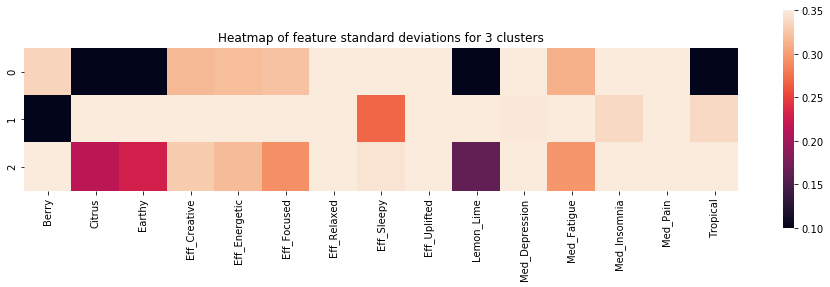

In [12]:
k=3
df_c, df_stds = make_df_c_stds(k)
intra_heatmap(k)

As expected given our previous analysis some of the low-column, "noisy" columns like Appearment, Apricot-Grapefruit, Eff_Aroused, Med_Cramps, and Med_Eye_pressure have a fairly similar std. We'll undoubtedly eliminate those later on.

More relevant the division of berry/blueberry, Sleepy, Lemon-Lime, Skunk, Sweet, and Tropical.  Also Creative, Tropical, Fatigue, Spicy/Herbal, and Woody.

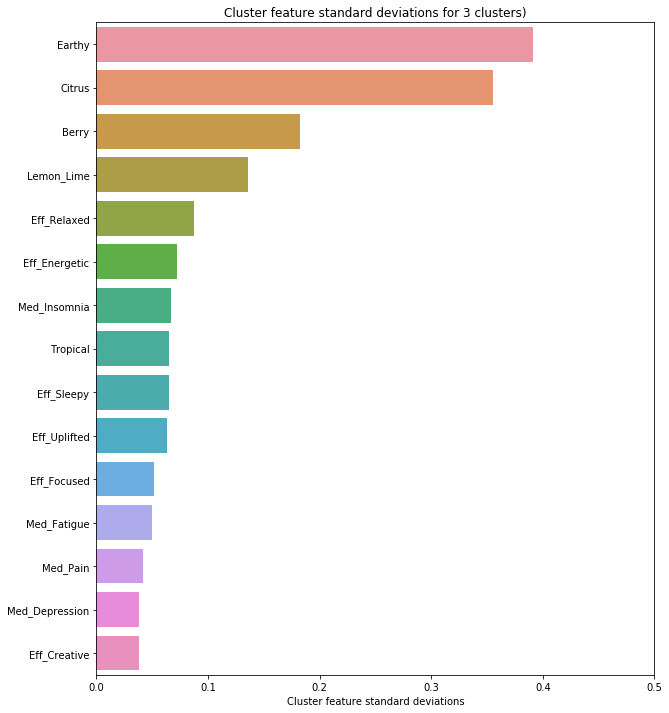

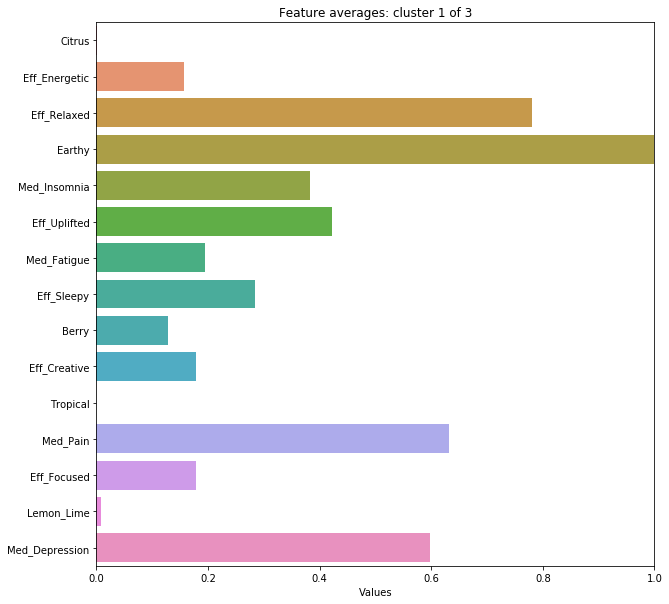

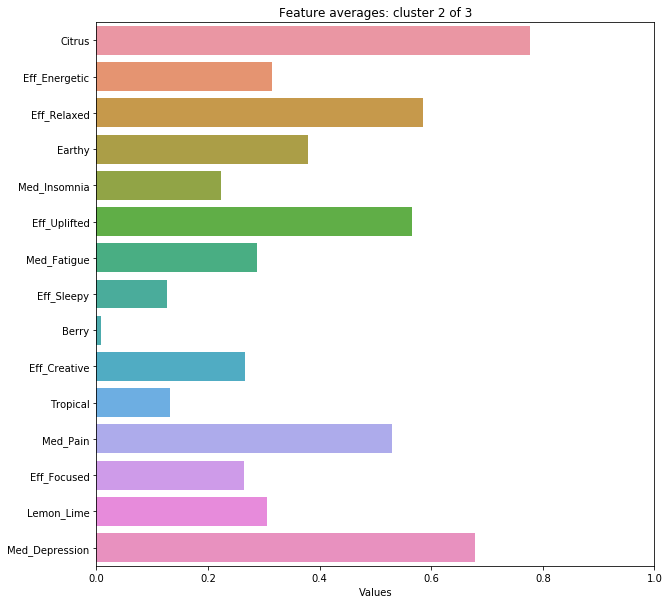

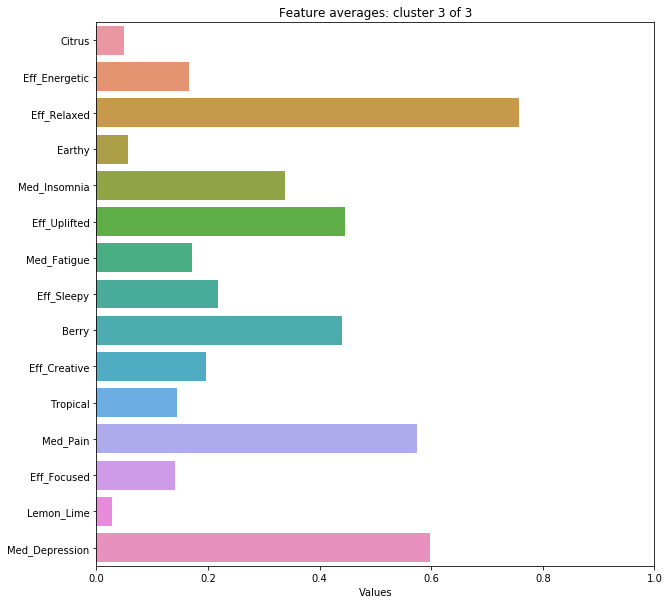

In [13]:
df_avg_std = make_df_avg_std(k, df_c)
cluster_stds = feature_bars(k, df_avg_std)

Out of our total 48 features, let's select all the features whose standard deviations are over 0.05. We'll do that for all our k-values and assess these series collecively to identify the features we'll retain in our best model.

### Analyze the split in the "green" group: k=4

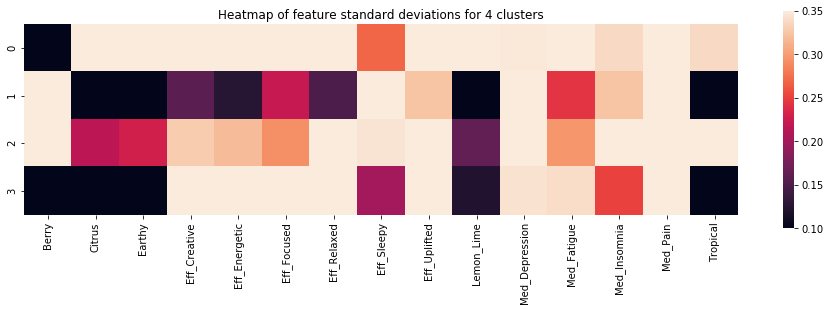

In [14]:
k=4
df_c, df_stds = make_df_c_stds(k)
intra_heatmap(k)

For k=2 one group has a lower variance for Berry/Blueberry, Eff_Giggly, Eff_Sleepy, Grape, Floewery, Skunk, and Woody. The other: Eff_Anxious, Eff_Energetic, Eff_Talkative, Eff_Fatigue, and Tropical.

In [15]:
df_avg_std

,Citrus,Eff_Energetic,Eff_Relaxed,Earthy,Med_Insomnia,Eff_Uplifted,Med_Fatigue,Eff_Sleepy,Berry,Eff_Creative,Tropical,Med_Pain,Eff_Focused,Lemon_Lime,Med_Depression
0,0.001218,0.156998,0.779798,0.998782,0.382940,0.421314,0.195142,0.283514,0.129111,0.179020,0.000000,0.632227,0.179279,0.008526,0.597760
1,0.777452,0.314365,0.584449,0.379209,0.223355,0.565671,0.287538,0.125992,0.007321,0.266620,0.131772,0.530039,0.264744,0.306003,0.678310
2,0.049521,0.166231,0.757384,0.055911,0.337010,0.445284,0.171204,0.217977,0.440895,0.195497,0.143770,0.574973,0.141620,0.027157,0.597276
3,0.355083,0.072106,0.087286,0.391209,0.067078,0.063164,0.050160,0.064610,0.182583,0.038011,0.065130,0.041819,0.051512,0.136053,0.038086


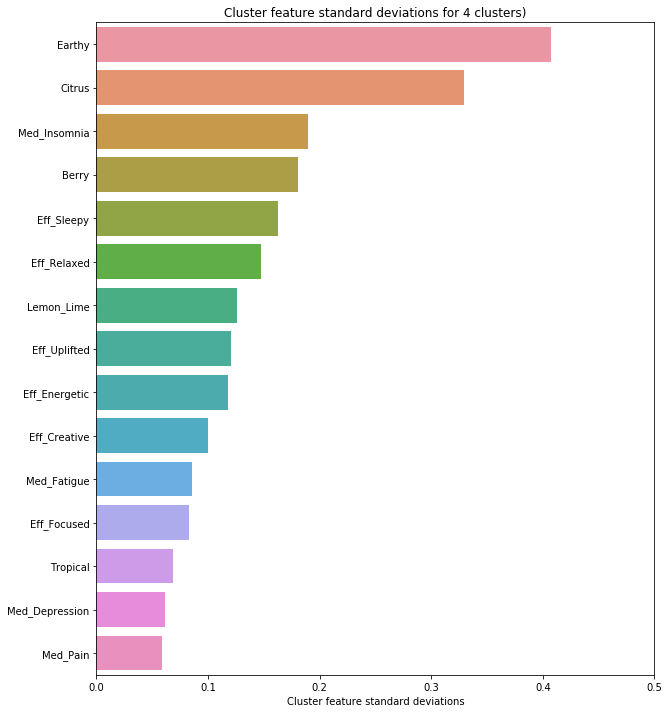

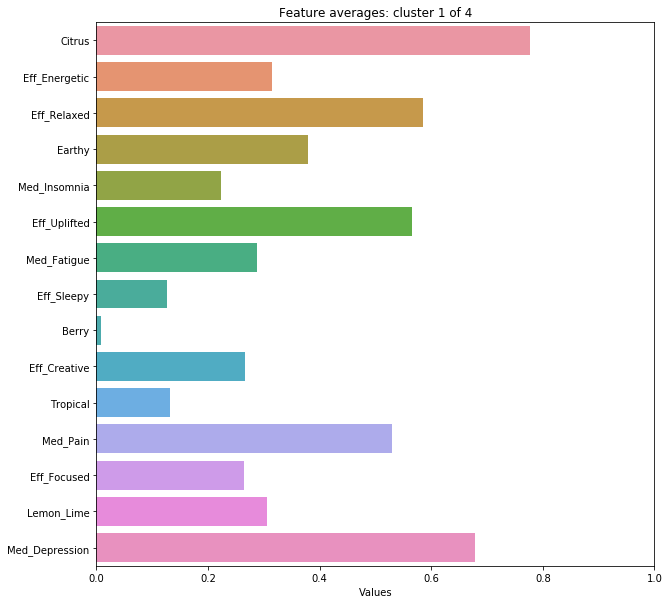

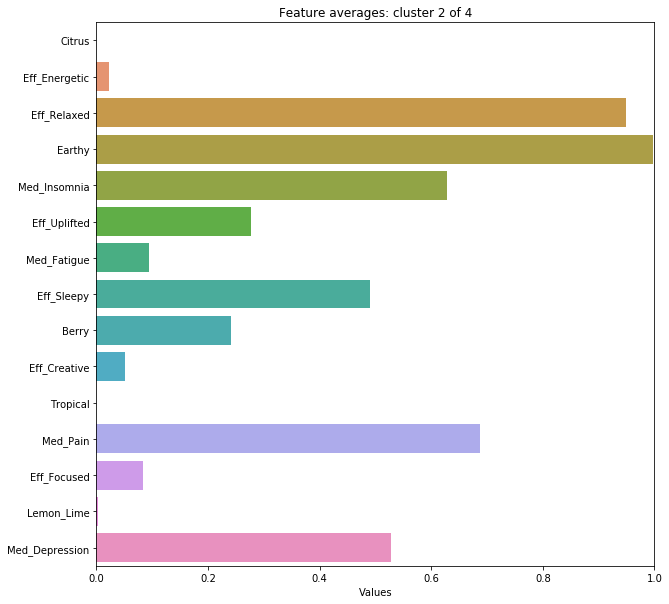

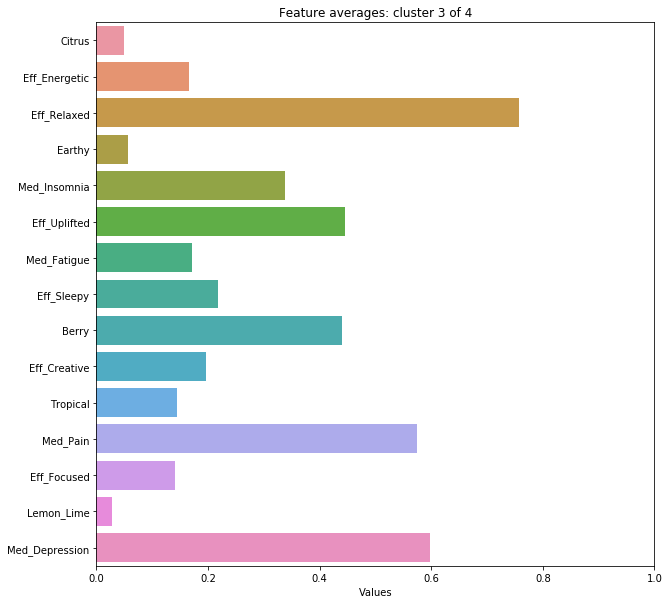

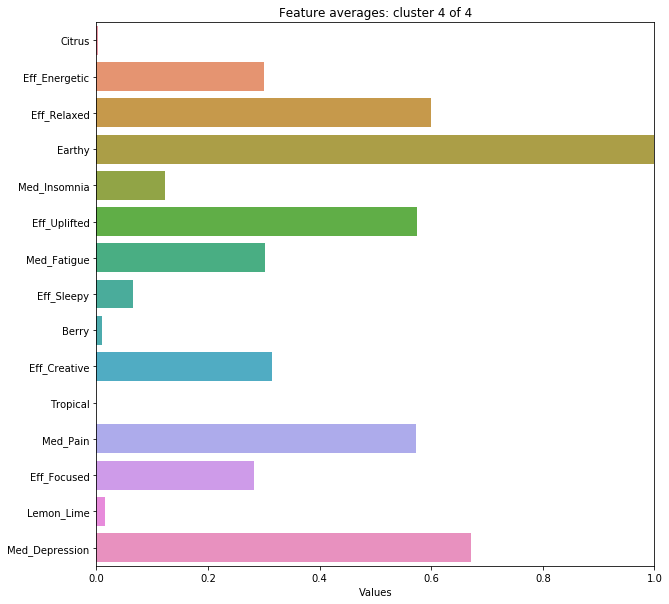

In [16]:
df_avg_std = make_df_avg_std(k, df_c)
cluster_stds = feature_bars(k, df_avg_std)

These two clusters have closer Sweet/Earthy values and vary more along Sleepy/Energetic, Citrus/Berry.

For our 4-feature model, clusters 2 and 4 combine to produce cluster 1 in the first model. Due to significant differences between critical properties of clusters 2 and 4, we'll selet the k=4 model.

# Cluster Descriptions for our best model: k=4, 15 features

Let's now more closely examine each cluster and describe them / give them meaningful names.

In [17]:
cluster_1 = df_avg_std.iloc[0].sort_values(ascending=False)
cluster_2 = df_avg_std.iloc[1].sort_values(ascending=False)
cluster_3 = df_avg_std.iloc[2].sort_values(ascending=False)
cluster_4 = df_avg_std.iloc[3].sort_values(ascending=False)

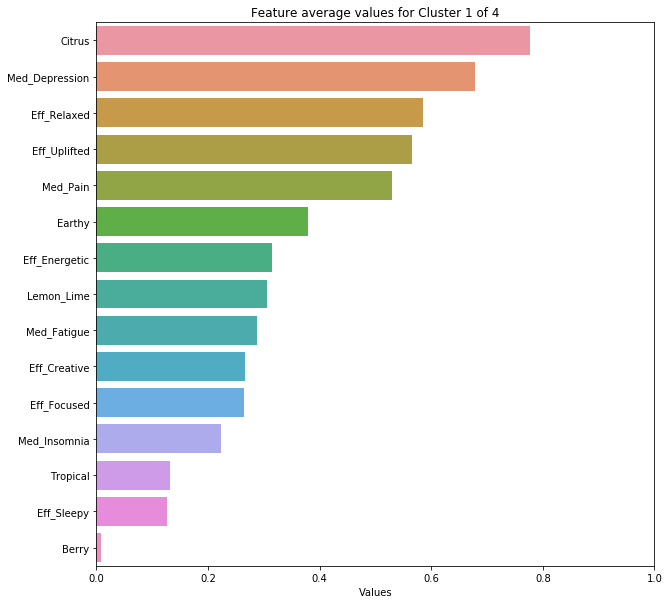

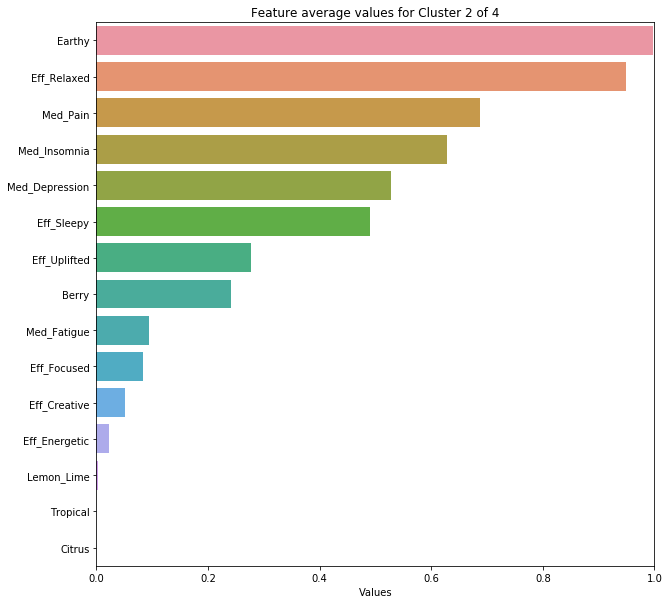

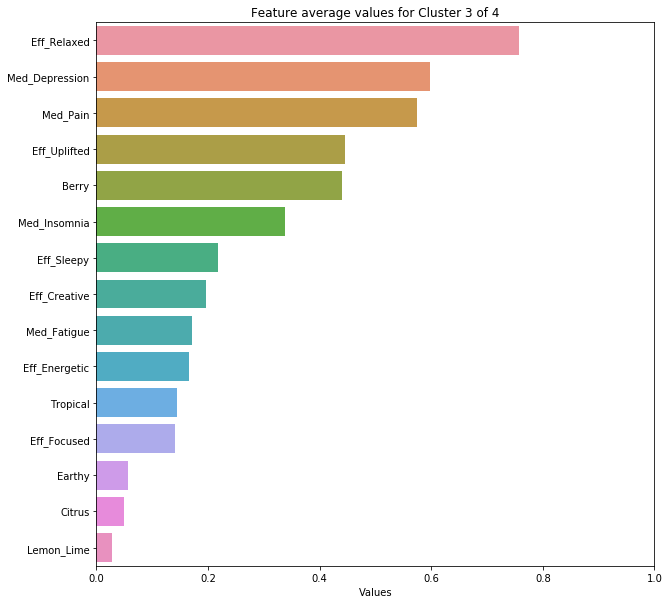

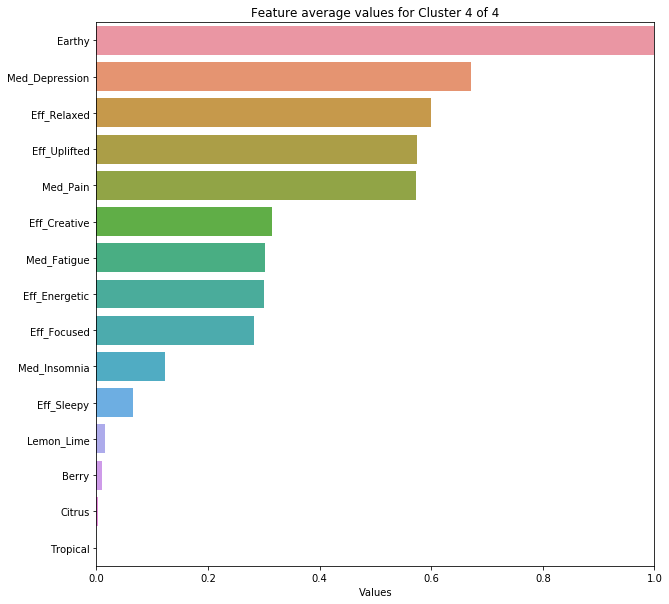

In [18]:
# CREATE AND SAVE ALL CLUSTER BAR GRAPHS

# Cluster 1
plt.figure(figsize=(10,10))
figure = sns.barplot(y=cluster_1.index, x=cluster_1.values)
plt.xlabel('Values')
plt.xlim(0,1)
plt.title(f'Feature average values for Cluster 1 of 4')
plt.show();
figure.figure.savefig(f'graphs/best_features_{1}_of_{4}')

# Cluster 2
plt.figure(figsize=(10,10))
figure = sns.barplot(y=cluster_2.index, x=cluster_2.values)
plt.xlabel('Values')
plt.xlim(0,1)
plt.title(f'Feature average values for Cluster 2 of 4')
plt.show();
figure.figure.savefig(f'graphs/best_features_{2}_of_{4}')

# Cluster 3
plt.figure(figsize=(10,10))
figure = sns.barplot(y=cluster_3.index, x=cluster_3.values)
plt.xlabel('Values')
plt.xlim(0,1)
plt.title(f'Feature average values for Cluster 3 of 4')
plt.show();
figure.figure.savefig(f'graphs/best_features_{3}_of_{4}')

# Cluster 4
plt.figure(figsize=(10,10))
figure = sns.barplot(y=cluster_4.index, x=cluster_4.values)
plt.xlabel('Values')
plt.xlim(0,1)
plt.title(f'Feature average values for Cluster 4 of 4')
plt.show();
figure.figure.savefig(f'graphs/best_features_{4}_of_{4}')

# Cluster descriptions

I have included averages only greater than 0.2 for each cluster. Features are listed in desending order of prevelance (more dominant cluster features listed first).

All clusters are taken for **Pain** (0.53-0.68) and **Depression** (0.52-0.67) in relatively comparable quantities. As such, they will not be listed below.

Features over 75% are ***bold and italic***, Features over 50% are **bold**. Features over 30% are *italic*

### Cluster 1: Lemon Leafs
- Flavours: ***citrus***, with *earthy*, and *lemon-lime*.
- Effects: **relaxed**, **uplifted**, *energetic*, creative, and focused
- Medical conditions: fatigue, insomnia

### Cluster 2 - Lights Out
- Flavours: ***100% earthy***, berry
- Effects: ***relaxed***, *sleepy*, *uplifted*
- Medical conditions: **insomnia**

### Cluster 3 - Berry Relaxed
- Flavours: *berry*
- Effects: ***relaxed***, *uplifted*, sleepy, creative
- Medical conditions: *insomnia*

### Cluster 4 - Rise and Shine
- Flavours: ***100% earthy***, 
- Effects: **relaxed**, **uplifted**, *creative*, *energetic*, focused
- Medical conditions: *fatigue*

In [19]:
df_avg_std.iloc[0:4]

,Citrus,Eff_Energetic,Eff_Relaxed,Earthy,Med_Insomnia,Eff_Uplifted,Med_Fatigue,Eff_Sleepy,Berry,Eff_Creative,Tropical,Med_Pain,Eff_Focused,Lemon_Lime,Med_Depression
0,0.777452,0.314365,0.584449,0.379209,0.223355,0.565671,0.287538,0.125992,0.007321,0.266620,0.131772,0.530039,0.264744,0.306003,0.678310
1,0.000000,0.022496,0.949539,0.997636,0.627902,0.277119,0.095048,0.489339,0.241135,0.050897,0.000000,0.688129,0.083144,0.002364,0.528402
2,0.049521,0.166231,0.757384,0.055911,0.337010,0.445284,0.171204,0.217977,0.440895,0.195497,0.143770,0.574973,0.141620,0.027157,0.597276
3,0.002513,0.299949,0.599394,1.000000,0.122591,0.574567,0.301523,0.064761,0.010050,0.315191,0.000000,0.572815,0.281453,0.015075,0.671475


# Comparing clusters to sativa/hybrid/indica categories

How do these categories breakdown by sativa/hybrid/indica? Since we have 3 categories for s/h/i we'll have to group our clusters in 3, not 4.

In [20]:
X['Strain_type'] = df.Strain_type.copy()

In [21]:
ARI = adjusted_rand_score(X.Strain_type, X.cluster_3)
ARI*100

1.9046555383171602

Not very much overlap at all! Even with 3 clusters our values do not map onto strain values very neatly.

Still, we can find out the strain-types composition of each of our clusters: 

In [22]:
len(X[X.cluster_4 == 1][X.Strain_type == 'indica'])

241

In [23]:
# What is the Strain_type breakdown for the entire data set?
df['Strain_type'].value_counts()

hybrid    1103
indica     600
sativa     427
Name: Strain_type, dtype: int64

In [24]:
strain_types = ['sativa', 'hybrid', 'indica']
clusters = [0,1,2,3]
cluster_values = []
for cluster in clusters:
    cluster_len = len(X[X.cluster_4 == cluster])
    for strain_type in strain_types:
        proportion = round(len(X[X.cluster_4 == cluster][X.Strain_type == strain_type])/cluster_len, 2)
        print(f'Cluster {cluster+1}: {proportion}% {strain_type}')
        cluster_values.append(proportion)
cluster_values

Cluster 1: 0.31% sativa
Cluster 1: 0.54% hybrid
Cluster 1: 0.15% indica
Cluster 2: 0.05% sativa
Cluster 2: 0.38% hybrid
Cluster 2: 0.57% indica
Cluster 3: 0.15% sativa
Cluster 3: 0.54% hybrid
Cluster 3: 0.31% indica
Cluster 4: 0.25% sativa
Cluster 4: 0.6% hybrid
Cluster 4: 0.15% indica


[0.31, 0.54, 0.15, 0.05, 0.38, 0.57, 0.15, 0.54, 0.31, 0.25, 0.6, 0.15]

- Cluster 1 is about 54% hybrid, 31% sativa, and 15% indica.
- Cluster 2 is about 57% indica, 38% hybrid, and 5% sativa
- Cluster 3 is about 54% hybrid, 31% indica, and 15% sativa
- Cluster 4 is about 60% hybrid, 25% sativa, and 15% indica

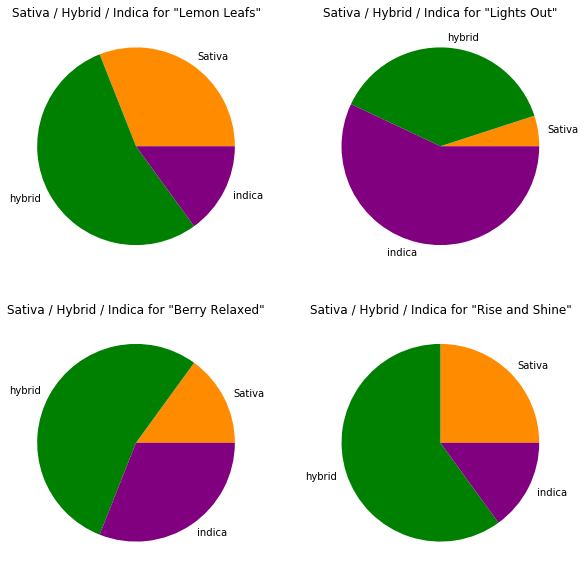

In [25]:
# PIE CHART

clust_1 = cluster_values[0:3]
clust_2 = cluster_values[3:6]
clust_3 = cluster_values[6:9]
clust_4 = cluster_values[9:12]

labels = ['Sativa', 'hybrid', 'indica']
colors = ['darkorange', 'green', 'purple']

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.pie(clust_1, labels=labels, colors=colors)
plt.title('Sativa / Hybrid / Indica for "Lemon Leafs"')
          
plt.subplot(2,2,2)
plt.pie(clust_2, labels=labels, colors=colors)
plt.title('Sativa / Hybrid / Indica for "Lights Out"')
          
plt.subplot(2,2,3)
plt.pie(clust_3, labels=labels, colors=colors)
plt.title('Sativa / Hybrid / Indica for "Berry Relaxed"')

plt.subplot(2,2,4)
plt.pie(clust_4, labels=labels, colors=colors)
plt.title('Sativa / Hybrid / Indica for "Rise and Shine"')
plt.show();

Going up a level, what proportion of the database does each cluster occupy?

In [26]:
X['cluster_4'].value_counts()

0    683
2    626
1    423
3    398
Name: cluster_4, dtype: int64

### Clusters in our dataframe
- Cluster 1: 683 - 32%
- Cluster 2: 626 - 29%
- Cluster 3: 423 - 20%
- Cluster 4: 398 - 19%

### Graph: Pie Chart of categories

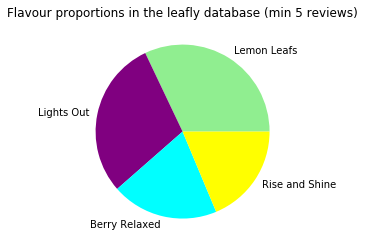

In [27]:
# PIE CHART
wedges = X['cluster_4'].value_counts().values
labels = ['Lemon Leafs', 'Lights Out', 'Berry Relaxed', 'Rise and Shine']
colors = ['lightgreen', 'purple', 'aqua', 'yellow']

plt.figure()
plt.pie(wedges, labels=labels, colors=colors)
plt.title('Flavour proportions in the leafly database (min 5 reviews)')
plt.show();

# OCS comparison

How do our findings compare with what's on offer at the OCS? Of the classifiable products in the Ontario Cannabis Store, how well do our categories span the product space currently on offer?

In [28]:
ocs = pd.read_csv('OCS.csv', index_col=None)

In [29]:
ocs.columns

Index(['Unnamed: 0', 'Name', 'Strain', 'Url', 'Description', 'Price',
       'Strain_type', 'Terpenes'],
      dtype='object')

In [30]:
X['Strain'] = df.Strain.copy()
X.head()

,Citrus,Eff_Energetic,Eff_Relaxed,Earthy,Med_Insomnia,Eff_Uplifted,Med_Fatigue,Eff_Sleepy,Berry,Eff_Creative,Tropical,Med_Pain,Eff_Focused,Lemon_Lime,Med_Depression,cluster_3,cluster_4,Strain_type,Strain
0,1.0,0.000000,1.000000,1.0,0.629377,0.551633,0.000000,0.978086,0.0,0.000000,0.0,0.700701,0.000000,0.0,0.000000,1,0,hybrid,$100 OG
1,0.0,0.680412,1.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.907216,0.0,0.240000,0.000000,0.0,0.000000,2,2,hybrid,'98 Aloha White Widow
2,0.0,0.812867,0.724043,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.0,0.256216,0.686099,0.0,0.827168,1,0,sativa,1024
3,1.0,0.000000,0.380952,0.0,0.000000,0.285714,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.000000,1,0,hybrid,13 Dawgs
4,1.0,1.000000,0.000000,0.0,0.000000,0.695652,0.666667,0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.0,1.000000,1,0,hybrid,22


In [31]:
X['in_ocs'] = 0
X['in_ocs'].sum()

0

In [32]:
for i in ocs['Name'].values:
    if i in X['Strain'].values:
        tempindex = X[X.Strain == i].index.values[0]
        X['in_ocs'].iloc[tempindex] = 1

In [33]:
X['in_ocs'].sum()

37

From our 71 scraped OCS strains 37 are in our database. Of these 37, how many belong to each cluster?

In [34]:
X[X['in_ocs']==1]['cluster_4'].value_counts()

1    13
0    11
3     9
2     4
Name: cluster_4, dtype: int64

### Clusters in the OCS database
- Cluster 1: 11 - 30%
- Cluster 2: 13 - 35%
- Cluster 3: 4  - 11%
- Cluster 4: 9  - 24%

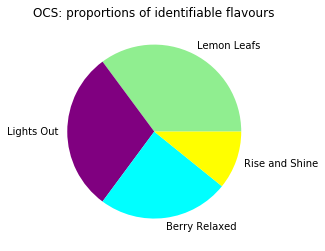

In [35]:
# PIE CHART
wedges = X[X['in_ocs']==1]['cluster_4'].value_counts().values
labels = ['Lemon Leafs', 'Lights Out', 'Berry Relaxed', 'Rise and Shine']

plt.figure()
plt.pie(wedges, labels=labels, colors=colors)
plt.title('OCS: proportions of identifiable flavours')
plt.show();

Comparing these to our values above, we see that cluster 2 is underrepresented (compared to the total recorded strains) by about 9%. The other clusters are off by at most 6% - surprisingly close, all things considered!

Whether or not these differences have any commercial significane or business-relevant interpretation is another question that is, unfortunatley, beyond the scope of this research.

In [36]:
df.columns

Index(['Strain', 'Lean', 'Sweet', 'Earthy', 'Spicy/Herbal', 'Tropical',
       'Pungent', 'Flowery', 'Blueberry', 'Berry', 'Pine', 'Woody', 'Citrus',
       'Diesel', 'Lemon_Lime', 'Appearment', 'Grape', 'Skunk', 'Eff_Focused',
       'Med_Inflammation', 'Eff_Dizzy', 'Eff_Energetic', 'Eff_Dry_eyes',
       'Med_Lack_of_appetite', 'Eff_Happy', 'Eff_Creative',
       'Med_Muscle_spasms', 'Eff_Sleepy', 'Med_Stress', 'Eff_Tingly',
       'Eff_Aroused', 'Eff_Anxious', 'Med_Nausea', 'Med_Fatigue', 'Med_Cramps',
       'Eff_Uplifted', 'Eff_Headache', 'Eff_Talkative', 'Eff_Paranoid',
       'Eff_Hungry', 'Eff_Giggly', 'Med_Depression', 'Eff_Relaxed', 'Med_Pain',
       'Eff_Euphoric', 'Med_Eye_pressure', 'Eff_Dry_mouth', 'Med_Headaches',
       'Med_Insomnia', 'Rating_scaled', 'Num_reviews_scaled', 'THC_scaled',
       'Strain_type', 'Apricot_Grapefruit'],
      dtype='object')

In [37]:
# df_export = X[['cluster_4', 'Strain', 'in_ocs']]
# df_export.to_csv('data/df_clusters.csv')

In [38]:
# out_df = df_avg_std.iloc[0:4]
# out_df.to_csv('data/df_group_averages.csv')

In [39]:
df_avg_std

,Citrus,Eff_Energetic,Eff_Relaxed,Earthy,Med_Insomnia,Eff_Uplifted,Med_Fatigue,Eff_Sleepy,Berry,Eff_Creative,Tropical,Med_Pain,Eff_Focused,Lemon_Lime,Med_Depression
0,0.777452,0.314365,0.584449,0.379209,0.223355,0.565671,0.287538,0.125992,0.007321,0.266620,0.131772,0.530039,0.264744,0.306003,0.678310
1,0.000000,0.022496,0.949539,0.997636,0.627902,0.277119,0.095048,0.489339,0.241135,0.050897,0.000000,0.688129,0.083144,0.002364,0.528402
2,0.049521,0.166231,0.757384,0.055911,0.337010,0.445284,0.171204,0.217977,0.440895,0.195497,0.143770,0.574973,0.141620,0.027157,0.597276
3,0.002513,0.299949,0.599394,1.000000,0.122591,0.574567,0.301523,0.064761,0.010050,0.315191,0.000000,0.572815,0.281453,0.015075,0.671475
4,0.329727,0.118020,0.147459,0.407010,0.189186,0.120235,0.085219,0.162329,0.180554,0.099700,0.069016,0.058602,0.083185,0.126371,0.061137


In [40]:
# df_avg_std.to_csv('data/df_avg_long.csv')

### Create df_avg_long - an array of averages for all flavours/effects/medicals.

In [41]:
extra_columns = list(Y.columns)

In [42]:
for col in list(Y.columns):
    if col not in list(X.columns):
        X[col] = Y[col]

Index(['Citrus', 'Eff_Energetic', 'Eff_Relaxed', 'Earthy', 'Med_Insomnia',
       'Eff_Uplifted', 'Med_Fatigue', 'Eff_Sleepy', 'Berry', 'Eff_Creative',
       'Tropical', 'Med_Pain', 'Eff_Focused', 'Lemon_Lime', 'Med_Depression',
       'cluster_3', 'cluster_4', 'Strain_type', 'Strain', 'in_ocs', 'Sweet',
       'Spicy/Herbal', 'Pungent', 'Flowery', 'Blueberry', 'Pine', 'Woody',
       'Diesel', 'Appearment', 'Grape', 'Skunk', 'Med_Inflammation',
       'Eff_Dizzy', 'Eff_Dry_eyes', 'Med_Lack_of_appetite', 'Eff_Happy',
       'Med_Muscle_spasms', 'Med_Stress', 'Eff_Tingly', 'Eff_Aroused',
       'Eff_Anxious', 'Med_Nausea', 'Med_Cramps', 'Eff_Headache',
       'Eff_Talkative', 'Eff_Paranoid', 'Eff_Hungry', 'Eff_Giggly',
       'Eff_Euphoric', 'Med_Eye_pressure', 'Eff_Dry_mouth', 'Med_Headaches',
       'Apricot_Grapefruit'],
      dtype='object')

In [43]:
X.drop(['Apricot_Grapefruit'], axis=1, inplace=True)

How make df_avg_long, ready to export.

In [47]:
df_c, df_stds = make_df_c_stds(4)
df_avg_long = make_df_avg_std(4, df_c)
df_avg_long = df_avg_long[0:4]
df_avg_long.shape

In [50]:
df_avg_long.to_csv('data/df_avg_long.csv')